importing the packages which are allowed as per the guildelines of the project

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import nltk
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import  svm
from sklearn.metrics import precision_recall_curve
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task1 Select two review categories of your choice. Scrape all reviews for each category and store them as two separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”). 

Definition of function scrape : this funcion has 2 arguments url(from which we have to take the data), catagory_no(the serial no. of catagory, 0 is Automotive, 1 is Bars, 2 is Health and medical, 3 is Hotels and travel, 4 is Restaurants) 
The motive of this function is to take out the data from the catagory choosen and then return the dataframe (it will be containing the review text and class label whether it is positive or negative), programming code lines are explained in the code below in the form of comments before the line

In [2]:
def scrape(url, catagory_no):
    # Connect to the URL
    response = requests.get(url)

    # Parse HTML and save to BeautifulSoup object¶
    soup = BeautifulSoup(response.text, "html.parser")

    # taking out the anchor tag with the index as the catagory_no taken from the function argument
    catagory = soup.findAll('a')[catagory_no]
    catagory_link = catagory['href']



    # forming the appropirate url
    catagory_url = 'http://mlg.ucd.ie/modules/yalp/'+ catagory_link


    # Connect to the URL
    catagory_response = requests.get(catagory_url)

    # Parse HTML and save to BeautifulSoup object¶
    catagory_soup = BeautifulSoup(catagory_response.text, "html.parser")
    
    # empty lists to store the stars and reviews
    catagory_stars_list=[]
    catagory_review_list=[]


    for i in range(0,len(catagory_soup.findAll('a'))): #'a' tags are for links
        one_a_tag = catagory_soup.findAll('a')[i]
        link = one_a_tag['href']
        download_url = 'http://mlg.ucd.ie/modules/yalp/'+ link
        catagory_final_response = requests.get(download_url)
        # Parse HTML and save to BeautifulSoup object¶
        catagory_final_soup = BeautifulSoup(catagory_final_response.text, "html.parser")
        stars_storage = catagory_final_soup.findAll('p', attrs={'class': 'stars'})
        for j in range(0,len(stars_storage)): 
            # taking out the img tags for stars data
            catagory_tag=stars_storage[j].img
            catagory_stars_list.append(catagory_tag['alt'].strip())
        # taking out thw review text from text class and getting the paragraph out of it
        review_storage = catagory_final_soup.findAll('p', attrs={'class': 'text'})
        for k in range(0,len(review_storage)):
            catagory_review_list.append(review_storage[k].text.strip())
    
    # classifying the data into appropriate class labels i.e. positive/negative  
    catagory_stars_list_sentiments=[]
    for i in range(0,len(catagory_stars_list)):
        if (catagory_stars_list[i]=='1-star' or catagory_stars_list[i]=='2-star' or catagory_stars_list[i]=='3-star'):
            catagory_stars_list_sentiments.append('negative')
        elif (catagory_stars_list[i]=='4-star' or catagory_stars_list[i]=='5-star'):
            catagory_stars_list_sentiments.append('positive')


    # making dictionary to store the review text and class label
    catagory_dict={'Review_Text':catagory_review_list,'Class_Label':catagory_stars_list_sentiments}
    
    # converting to dataframe
    dframe=pd.DataFrame(catagory_dict)
    
    return dframe;

### Task2 For both category datasets:
### 2.1 From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.

the function below will perform the certain set of steps to do the preprocessing phase, it will perform the cleaning of text by removing all the special characters, removing all the single characters, removing single characters from the begining, subsituting multiple spaces with the single space, converting to lowercase, performing lemmatization and finally it will give the tf idf representation of the text.

In [3]:
def preprocessing(dframe):
    documents = []

    stemmer = WordNetLemmatizer()

    for s in range(0, len(dframe['Review_Text'])):  
    
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(dframe['Review_Text'][s]))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    
    # converting into tf idf representation 
    tfidfconverter = TfidfVectorizer(max_features=1500,min_df=5, max_df=0.7,  stop_words=stopwords.words('english'))  
    X = tfidfconverter.fit_transform(documents).toarray()
        
    return X;

Below is the function for plotting the confusion matrix

In [4]:
def confusion_matrix_plot(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

below is the code to transfer the data into csv file

In [5]:
# scraping the data for catagory 1, In my case i have taken catagory 'Automotive'
catagory1 =scrape('data-path1',0);

    
# scraping the data for catagory 2, In my case i have taken catagory 'Bars'
catagory2 =scrape('data-path2',1);
    
# storing the result in csv files
catagory1.to_csv('catagory1.csv',index=False)
    
catagory2.to_csv('catagory2.csv',index=False)

### 2.2 Build a classification model using a classifier of your choice, to distinguish between “positive” and “negative” reviews

### 2.3 Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook

Below cells are performing the task need to be performed in 2.3 and 2.2, it is evaluating the random forest model for catagory1 and catagory2 dataset using the hold out evaluation strategy, and in the end, the comparison of 2 catagories is done on the basis of various parameters like confusion matrix, classification matix and accuracy score. these comparisons are also shown in the form of carious plots like confusion matrix, ROC curves and precision recall curves. 

The confusion matrix for catagory1 data i.e. 'Automotive' is shown below: 
[[ 58  28]
 [  2 203]]
The classification matrix for catagory1 data i.e. 'Automotive' is shown below: 
             precision    recall  f1-score   support

   negative       0.97      0.67      0.79        86
   positive       0.88      0.99      0.93       205

avg / total       0.90      0.90      0.89       291

The accuracy score for catagory1 data i.e. 'Automotive' is shown below: 
0.8969072164948454



The plot of confusion matrix for catagory 1 is shown below:


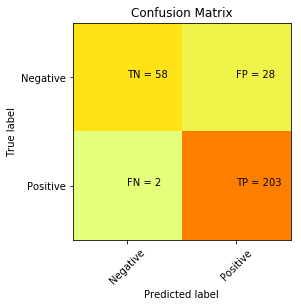





The confusion matrix for catagory2 data i.e. 'Bars' is shown below: 
[[ 71  33]
 [ 14 174]]
The classification matrix for catagory2 data i.e. 'Bars' is shown below: 
             precision    recall  f1-score   support

   negative       0.84      0.68      0.75       104
   positive       0.84      0.93      0.88       188

avg / total       0.84      0.84      0.83       292

The accuracy score for catagory2 data i.e. 'Bars' is shown below: 
0.839041095890411



The plot of confusion matrix for catagory 2 is shown below:


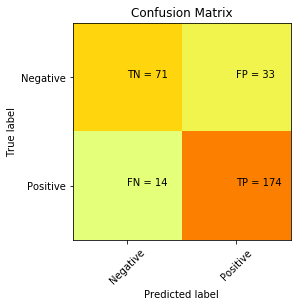

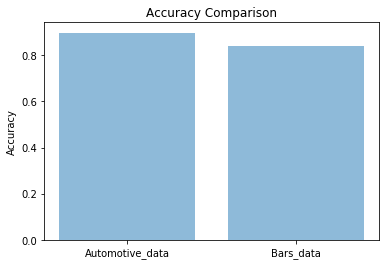

The score of Automotive data from k fold cross valiadtion is : [0.86986301 0.8869863  0.87628866 0.85862069 0.86206897]


The score of Bars data from k fold cross valiadtion is : [0.85958904 0.79794521 0.83219178 0.80479452 0.82876712]
The mean score of Automotive data from k fold cross valiadtion is : 0.8707655260069442


The mean score of Automotive data from k fold cross valiadtion is : 0.8246575342465754


In [15]:
# loading the data from csv's
catagory1=pd.read_csv('catagory1.csv');
catagory2=pd.read_csv('catagory2.csv');

    
# applying preprocessing on the data
X1=preprocessing(catagory1);
X2=preprocessing(catagory2);
    
# spliting the data using hold out evaluation startegy
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, catagory1['Class_Label'], test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, catagory2['Class_Label'], test_size=0.2, random_state=0)
    
    
# applying random forest classification model on catagory 1 dataset 
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)  
classifier.fit(X_train1, y_train1)
    
y_pred1 = classifier.predict(X_test1)
 
    
#make confusion matrix
print("The confusion matrix for catagory1 data i.e. 'Automotive' is shown below: ")
cm1=confusion_matrix(y_test1,y_pred1)
print(cm1)  
print("The classification matrix for catagory1 data i.e. 'Automotive' is shown below: ")
print(classification_report(y_test1,y_pred1))  
print("The accuracy score for catagory1 data i.e. 'Automotive' is shown below: ") 
accuracy_catagory1=accuracy_score(y_test1, y_pred1)
print(accuracy_catagory1)
print('\n\n');
print("The plot of confusion matrix for catagory 1 is shown below:")
confusion_matrix_plot(cm1)

# applying random forest classification model on catagory 2 dataset 
classifier2 = RandomForestClassifier(n_estimators=1000, random_state=0)  
classifier2.fit(X_train2, y_train2)
    
y_pred2 = classifier2.predict(X_test2)
 
    
#make confusion matrix for catagory2
print('\n')
print('\n')
print("The confusion matrix for catagory2 data i.e. 'Bars' is shown below: ")
cm2=confusion_matrix(y_test2,y_pred2)
print(cm2)  
print("The classification matrix for catagory2 data i.e. 'Bars' is shown below: ")
print(classification_report(y_test2,y_pred2))  
print("The accuracy score for catagory2 data i.e. 'Bars' is shown below: ")
accuracy_catagory2=accuracy_score(y_test2, y_pred2)
print(accuracy_catagory2)
print('\n\n');
print("The plot of confusion matrix for catagory 2 is shown below:")
confusion_matrix_plot(cm2)
objects = ('Automotive_data', 'Bars_data')
y_pos = np.arange(len(objects))
performance = [accuracy_catagory1,accuracy_catagory2]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()
    
    
    
    
# k fold cross validation
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(classifier, X1, catagory1['Class_Label'], cv=5,scoring="accuracy")
scores2 = cross_val_score(classifier2, X2, catagory2['Class_Label'], cv=5,scoring="accuracy")
print("The score of Automotive data from k fold cross valiadtion is :",scores1)
print('\n')
print("The score of Bars data from k fold cross valiadtion is :",scores2)


print("The mean score of Automotive data from k fold cross valiadtion is :",scores1.mean())
print('\n')
print("The mean score of Automotive data from k fold cross valiadtion is :",scores2.mean())
    
    

Below is the function for transformation of class labels to the binary values(0 for negative and 1 for positive), in order to make roc and precision recall curves.

In [9]:
def label_to_binary(y_test1,y_pred1,y_test2,y_pred2):
    # converting the test class labels to binary values for automotive data
    for i in range(len(y_test1)):
        if y_test1.values[i]=='positive':
            y_test1.values[i]=1
        else:
            y_test1.values[i]=0
        
    # converting the test class labels to binary values for bars data
    for i in range(len(y_test2)):
        if y_test2.values[i]=='positive':
            y_test2.values[i]=1
        else:
            y_test2.values[i]=0
        
    # converting the prediction class labels to binary values for automotive data      
    for i in range(len(y_pred1)):
        if y_pred1[i]=='positive':
            y_pred1[i]=1
        else:
            y_pred1[i]=0

    # converting the prediction class labels to binary values for bars data     
    for i in range(len(y_pred2)):
        if y_pred2[i]=='positive':
            y_pred2[i]=1
        else:
            y_pred2[i]=0
        


Below is the function for implementation of ROC curves for automotive and bars data.
A Receiver Operating Characteristic (ROC Curve) is a graphical plot of how the true positive rate and false positive rate change over many different thresholds. The curve is drawn by plotting a point for each feasible threshold and joining them. The strength of the classifier increases as the ROC curve moves further from the line (i.e. closer to top left corner).
A better classifier will have a ROC curve closer to top-left corner, giving a larger area under the curve.

In terms of AUC automotive data is performing well.


In [13]:
def roc(y_test1,y_pred1,y_test2,y_pred2,title1,title2):
    # drawing the roc curve for catagory 1 i.e. 'Automotive' data         
    fig, ax = plt.subplots(figsize=(12,8))
    plt.subplot(1, 2, 1)
    fpr1, tpr1, t1= metrics.roc_curve(y_test1.values.astype(int),y_pred1.astype(int))
    auc = metrics.roc_auc_score(y_test1.values.astype(int),y_pred1.astype(int))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr1,tpr1,label="Automotive Data, auc="+str(auc))
    plt.title(title1)
    plt.legend(loc=4)
    #plt.show()


    # drawing the roc curve for catagory 2 i.e. 'Bars' data
    plt.subplot(1, 2, 2)
    fpr2, tpr2, t2= metrics.roc_curve(y_test2.values.astype(int),y_pred2.astype(int))
    auc2 = metrics.roc_auc_score(y_test2.values.astype(int),y_pred2.astype(int))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr2,tpr2,label="Bars Data, auc="+str(auc2))
    plt.title(title2)
    plt.legend(loc=4)
    plt.show()




Below is the function for implementation of precision and recall curves for Automotive and Bars data.
Precision Recall curve will reveal that for a given value of recall what precision we are receiving and a plot of precision vs. recall are summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

In [11]:
def pr_curve(y_test1,y_pred1,y_test2,y_pred2,title1,title2):
    plt.subplots(figsize=(12,8))
    plt.subplot(1,2,1)
    precision1, recall1, thresholds1 = precision_recall_curve(y_test1.values.astype(int),y_pred1.astype(int))

    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.title(title1)
    # plot the precision-recall curve for the model
    plt.plot(recall1, precision1, marker='.')
    # show the plot
    #plt.show()

    plt.subplot(1,2,2)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test2.values.astype(int),y_pred2.astype(int))

    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.title(title2)
    # plot the precision-recall curve for the model
    plt.plot(recall2, precision2, marker='.')
    # show the plot
    plt.show()


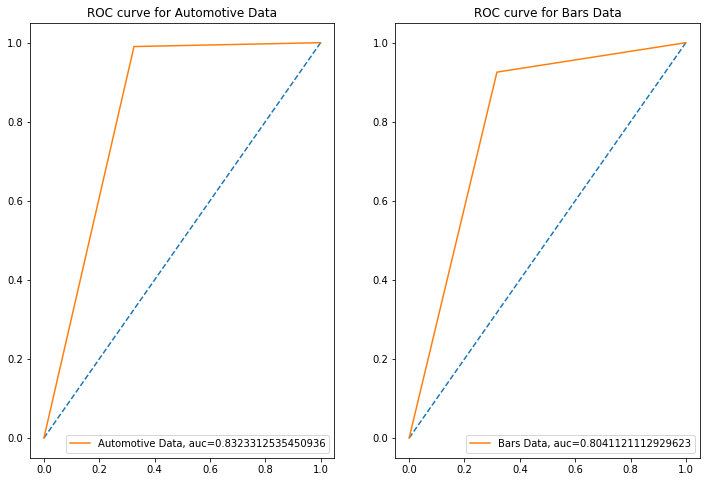

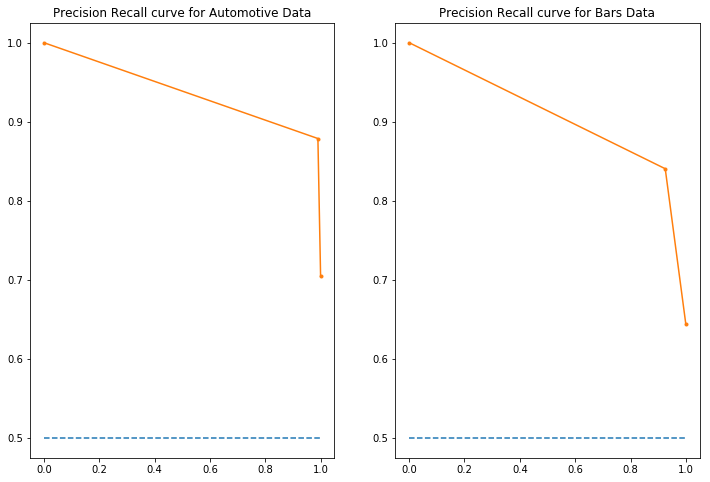

In [16]:
label_to_binary(y_test1,y_pred1,y_test2,y_pred2);
roc(y_test1,y_pred1,y_test2,y_pred2,'ROC curve for Automotive Data','ROC curve for Bars Data');
pr_curve(y_test1,y_pred1,y_test2,y_pred2,'Precision Recall curve for Automotive Data','Precision Recall curve for Bars Data');

After running the above function for task 2.2 and 2.3, we can see that in terms of accuracy, automotive data and bars data is almost same and in terms of confusion matrix also the automotive data and bars data is almost same and in terms of classification matrix also the automotive data and bars data is almost same. There is very little difference in the evaluation parameters value, the reason of this might be due to the fact that data in both categories are in different domains and also class imbalance because when we use the hold out evaluation strategy then Data sets are unbalanced when at least one class is represented by only a small number of training examples (called the minority class) while other classes make up the majority, therefore i have applied the k fold cross( by keeping the k=5 )validation to check the results, the results of accuracy are almost same again with very little difference. 

### Task 3: Evaluate how well your two classification models transfer between category. That is, run experiments to:
### 3.1 Train a classification model on the data from “Category A”, and evaluate its performance on the data from “Category B”.


Below cell of code will perform the task which is  needed to be performed in 3.1, it is training the naive bayes model on catagory1 training data and then evaluating it from catagory 2 test data, next it will be training the naive bayes model on catagory2 training data and then evaluating it from catagory 1 test data.




The results when Naive bayes is trained on automotive data and tested on bars data are shown below:



0.589041095890411


confusion matrix
[[ 45  59]
 [ 61 127]]


classification matrix
             precision    recall  f1-score   support

   negative       0.42      0.43      0.43       104
   positive       0.68      0.68      0.68       188

avg / total       0.59      0.59      0.59       292



Accuracy Score
0.589041095890411



The plot of confusion matrix for automotive training data is shown below:


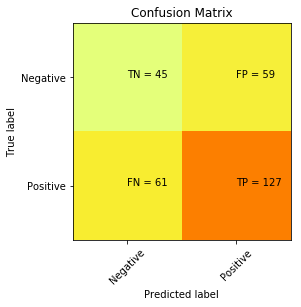




The results when Naive bayes is trained on bars data and tested on automotive data are shown below:



0.5463917525773195


confusion matrix
[[ 37  49]
 [ 83 122]]


classification matrix
             precision    recall  f1-score   support

   negative       0.31      0.43      0.36        86
   positive       0.71      0.60      0.65       205

avg / total       0.59      0.55      0.56       291



accuracy
0.5463917525773195



The plot of confusion matrix for bars training data is shown below:


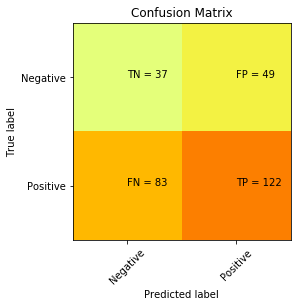

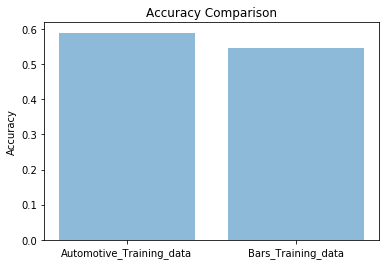

In [17]:
# loading the data from csv's
catagory1=pd.read_csv('catagory1.csv');
catagory2=pd.read_csv('catagory2.csv');
    
# applying preprocessing on the data
X1=preprocessing(catagory1);
X2=preprocessing(catagory2);
    
# spliting the data using hold out evaluation startegy
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, catagory1['Class_Label'], test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, catagory2['Class_Label'], test_size=0.2, random_state=0)
    
    
model = MultinomialNB().fit(X_train1, y_train1)
predicted = model.predict(X_test2)

print('\n\n')
print('The results when Naive bayes is trained on automotive data and tested on bars data are shown below:')
print('\n\n')
print(np.mean(predicted == y_test2))
print('\n')
print('confusion matrix')
cm1=confusion_matrix(y_test2,predicted)
print(cm1)  
print('\n')
print('classification matrix')
print(classification_report(y_test2,predicted)) 
print('\n')
print('Accuracy Score')
automotive_accuracy=accuracy_score(y_test2, predicted)
print(automotive_accuracy)
print('\n\n')
print("The plot of confusion matrix for automotive training data is shown below:")
confusion_matrix_plot(cm1)

model2 = MultinomialNB().fit(X_train2, y_train2)

predicted2 = model2.predict(X_test1)

print('\n\n')
print('The results when Naive bayes is trained on bars data and tested on automotive data are shown below:')
print('\n\n')
print(np.mean(predicted2 == y_test1))
print('\n')
print('confusion matrix')
 
cm2=confusion_matrix(y_test1,predicted2)
print(cm2) 
print('\n')
print('classification matrix')
 
print(classification_report(y_test1,predicted2))  
print('\n')
print('accuracy')
bars_accuracy=accuracy_score(y_test1, predicted2)
print(bars_accuracy)
print('\n\n');
print("The plot of confusion matrix for bars training data is shown below:")
confusion_matrix_plot(cm2)
objects = ('Automotive_Training_data', 'Bars_Training_data')
y_pos = np.arange(len(objects))
performance = [automotive_accuracy,bars_accuracy]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()


From the above results, we can say that when we train the naive bayes on automotive data and test it on bars data then it is performing almost same as when we train the naive bayes on bars data and test it on automotive data in terms of accuracy, f1 score and precision which are the crucial factors to evaluate any model

Below the ROC and precision-Recall curve for task 3.2 and in case of Naive Bayes classifier when we train on automotive data and test on bars data, then It is performing same as in case of Naive Bayes classifier when we train on bars data and test on automotive data there auc is almost same and same is the case with precision score.

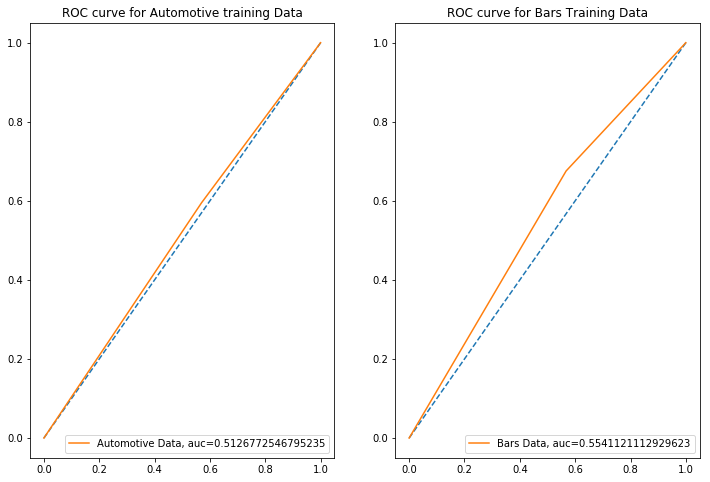

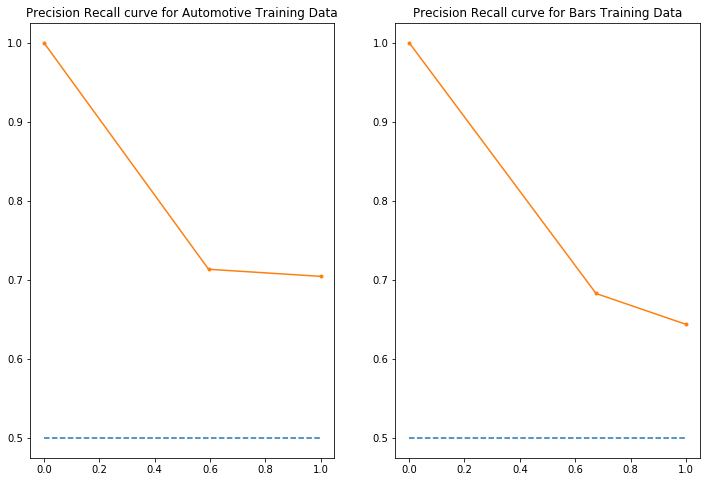

In [18]:
label_to_binary(y_test1,predicted2,y_test2,predicted);
roc(y_test1,predicted2,y_test2,predicted,'ROC curve for Automotive training Data','ROC curve for Bars Training Data');
pr_curve(y_test1,predicted2,y_test2,predicted,'Precision Recall curve for Automotive Training Data','Precision Recall curve for Bars Training Data');

### 3.2 Train a classification model on the data from “Category B”, and evaluate its performance on the data from “Category A”

Below function is performing the task need to be performed in 3.1, it is training the svm model on catagory1 training data and then evaluating it from catagory 2 test data, next it will be training the svm model on catagory2 training data and then evaluating it from catagory 1 test data.




The results when SVM is trained on automotive data and tested on bars data are shown below:



SVM Accuracy Score ->  61.64383561643836


confusion matrix


[[ 41  63]
 [ 49 139]]


classification matrix


             precision    recall  f1-score   support

   negative       0.46      0.39      0.42       104
   positive       0.69      0.74      0.71       188

avg / total       0.61      0.62      0.61       292



Accuracy score


0.6164383561643836



The plot of confusion matrix for automotive training data is shown below:


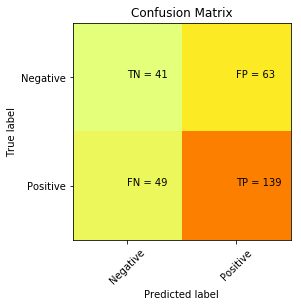




The results when SVM is trained on bars data and tested on automotive data are shown below:



SVM Accuracy Score ->  58.4192439862543


confusion_matrix


[[ 36  50]
 [ 71 134]]


classification_matrix


             precision    recall  f1-score   support

   negative       0.34      0.42      0.37        86
   positive       0.73      0.65      0.69       205

avg / total       0.61      0.58      0.60       291



Accuracy


0.584192439862543



The plot of confusion matrix for bars training data is shown below:


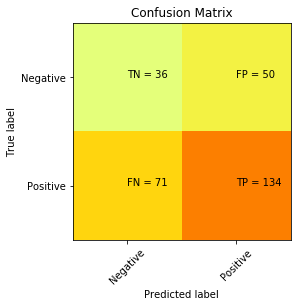

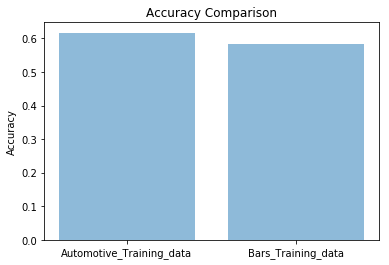

In [19]:
# loading the data from csv's
catagory1=pd.read_csv('catagory1.csv');
catagory2=pd.read_csv('catagory2.csv');

    
# applying preprocessing on the data
X1=preprocessing(catagory1);
X2=preprocessing(catagory2);
    
# spliting the data using hold out evaluation startegy
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, catagory1['Class_Label'], test_size=0.2, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, catagory2['Class_Label'], test_size=0.2, random_state=0)
    
    
    

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train1, y_train1)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test2)
# Use accuracy_score function to get the accuracy
print('\n\n')
print('The results when SVM is trained on automotive data and tested on bars data are shown below:')
print('\n\n')
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test2)*100) 

print('\n')
print('confusion matrix')
print('\n')
cm1=confusion_matrix(y_test2,predictions_SVM )
print(cm1) 
print('\n')
print('classification matrix')
print('\n')
print(classification_report(y_test2,predictions_SVM ))
print('\n')
print('Accuracy score')
print('\n')
automotive_accuracy=accuracy_score(y_test2, predictions_SVM )
print(automotive_accuracy)
print('\n\n')
print("The plot of confusion matrix for automotive training data is shown below:")
confusion_matrix_plot(cm1)


SVM2 = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM2.fit(X_train2, y_train2)
# predict the labels on validation dataset
predictions_SVM2 = SVM2.predict(X_test1)
print('\n\n')
print('The results when SVM is trained on bars data and tested on automotive data are shown below:')
print('\n\n')
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM2, y_test1)*100)
print('\n')
print('confusion_matrix')
print('\n')
cm2=confusion_matrix(y_test1, predictions_SVM2)
print(cm2) 


print('\n')
print('classification_matrix')
print('\n')  
print(classification_report(y_test1,predictions_SVM2))
print('\n')
print('Accuracy')
print('\n')
bars_accuracy=accuracy_score(y_test1, predictions_SVM2)
print(bars_accuracy)
print('\n\n')
print("The plot of confusion matrix for bars training data is shown below:")
confusion_matrix_plot(cm2)


objects = ('Automotive_Training_data', 'Bars_Training_data')
y_pos = np.arange(len(objects))
performance = [automotive_accuracy,bars_accuracy]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()


From the above results, we can say that when we train the SVM on automotive data and test it on bars data then it is performing almost same as when we train the SVM on bars data and test it on automotive data in terms of accuracy, f1 score and precision which are the crucial factors to evaluate any model

Below the ROC and precision-Recall curve for task 3.2 and in case of SVM classifier when we train on automotive data and test on bars data, then It is performing same as in case of SVM classifier when we train on bars data and test on automotive data there auc is almost same and same is the case with precision score.

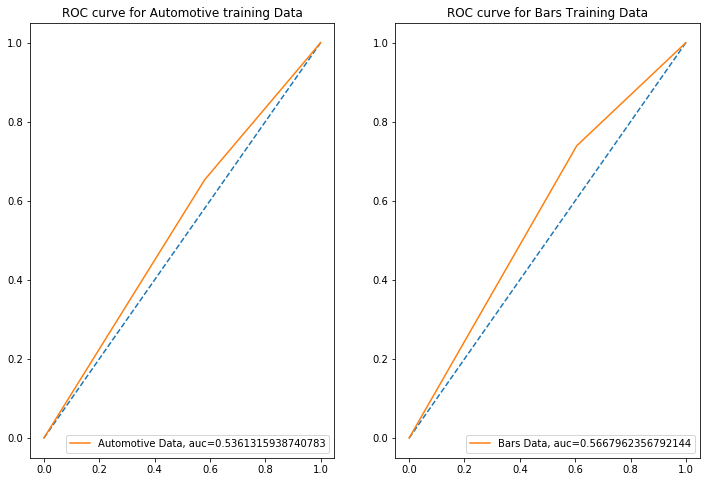

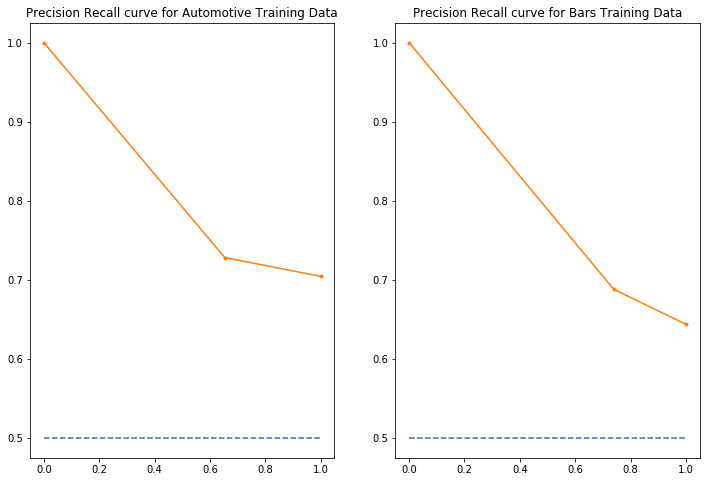

In [20]:
label_to_binary(y_test1,predictions_SVM2,y_test2,predictions_SVM);
roc(y_test1,predictions_SVM2,y_test2,predictions_SVM,'ROC curve for Automotive training Data','ROC curve for Bars Training Data');
pr_curve(y_test1,predictions_SVM2,y_test2,predictions_SVM,'Precision Recall curve for Automotive Training Data','Precision Recall curve for Bars Training Data');

### Tentative Conclusion

Text classification is one of the most commonly used NLP tasks. It is the process of classifying text strings or documents into different categories, depending upon the contents of the strings. In this project, I have scraped the data from the yelp website and then stored it into the csv files, next i have performed the preprocessing on it in order to get the clean data and after all these things, the classification model is applied to it.
for task 2 i have applied the random forest classifier and got almost same evalation scores for both the catagories of data.
for task 3.1 i have applied the naive bayes to train it on the catagory 1 data and then test it on the catagory 2 data, then i have applied the naive bayes to train it on the catagory 2 data and then test it on the catagory 1 data.
for task 3.2 i have applied the svm to train it on the catagory 1 data and then test it on the catagory 2 data, then i have applied the svm to train it on the catagory 2 data and then test it on the catagory 1 data.
the results were drawn from vaious parameters like roc, precision recall, confusion matrix, accuracy score. the values for these score were almost same (one is little lesser than other), the reason of that could be due to the domain of data or class imbalance.
i got 89% accuracy on catagory 1 data and 83% accuracy on catagory 2 data when i applied random forest classifier using hold out startegy.
i got 58% accuracy when trained on catagory 1 data and tested on catagory 2 data when i applied naive bayes classifier using hold out startegy
i got 54% accuracy when trained on catagory 2 data and tested on catagory 1 data when i applied naive bayes classifier using hold out startegy
i got 61% accuracy when trained on catagory 1 data and tested on catagory 2 data when i applied svm classifier using hold out startegy
i got 58% accuracy when trained on catagory 2 data and tested on catagory 1 data when i applied svm classifier using hold out startegy.
The above proposed solution is fairly easy to extend, we can apply more machine learning algorithms and then check if we can improve performance.